In [1]:
import basis_set_exchange as bse
import scipy as sp
import matplotlib.pyplot as plt
from pyscf import gto,scf
import copy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from pyscf.data.elements import _symbol
from pyscf.grad import RHF as g
import inspect
import sys
sys.path.append("../Libs")
from FcMole import FcM,FcM_like
from FDcoeffs import get_coeffs
from ao_scf import ao_RHF
from numpy.linalg import norm

In [2]:
from functools import reduce
import ctypes

import numpy
from pyscf import lib
from pyscf import gto
from pyscf.lib import logger
from pyscf.scf import _vhf
from pyscf.scf import cphf

# import _response_functions to load gen_response methods in SCF class
from pyscf.scf import _response_functions  # noqa
# import pyscf.grad.rhf to activate nuc_grad_method method
from pyscf.grad import rhf  # noqa

In [3]:
def make_dP(mf,mo1):
    mol=mf.mol
    nao=mol.nao
    nocc=mf.mol.nelec[0]
    C=mf.mo_coeff
    dP=np.zeros_like(C)
    dP[:,:]=2*np.einsum('ij,jk,lk->il',C,mo1,C[:,:nocc])
    return dP+dP.T

def make_U(mo1):
    U=np.zeros((mo1.shape[0],mo1.shape[0]))
    U[:,:mo1.shape[1]]=mo1
    U=U-U.T
    return U

In [4]:
nn=gto.M(atom="C 0 0 0; O 0 0 2.05",unit="Bohr",basis=bse.get_basis("6-31g",fmt="nwchem",elements=[6,7,8]))
mol=nn
mf_nn=scf.RHF(nn)
e_nn=mf_nn.scf()
P_nn=mf_nn.make_rdm1()
########
nn_p=gto.M(atom="C 0 0 0; O 0 0 2.08",unit="Bohr",basis=bse.get_basis("6-31g",fmt="nwchem",elements=[6,7,8]))
mf_nn_p=scf.RHF(nn_p)
e_nn_p=mf_nn_p.scf()
P_nn_p=mf_nn_p.make_rdm1()
########
nn_m=gto.M(atom="C 0 0 0; O 0 0 2.02",unit="Bohr",basis=bse.get_basis("6-31g",fmt="nwchem",elements=[6,7,8]))
mf_nn_m=scf.RHF(nn_m)
e_nn_m=mf_nn_m.scf()
P_nn_m=mf_nn_m.make_rdm1()

converged SCF energy = -112.661562568708
converged SCF energy = -112.664890518986
converged SCF energy = -112.65657514208


In [5]:
import pyscf.hessian # needed to use hessian

In [6]:
h_nn=mf_nn.Hessian()
mf=mf_nn

In [7]:
h_nn.hess(),h_nn.hess()[1,1,2,2]

(array([[[[-6.71352251e-02, -8.20765439e-17,  3.29899130e-16],
          [-6.62896055e-17, -6.71352251e-02, -3.88304719e-17],
          [ 3.29899129e-16, -3.88304715e-17,  1.84234812e+00]],
 
         [[ 6.71352251e-02,  6.62896055e-17, -3.29899129e-16],
          [ 8.29439056e-17,  6.71352251e-02,  3.88304715e-17],
          [-3.29899130e-16,  3.88304719e-17, -1.84234812e+00]]],
 
 
        [[[ 6.71352251e-02,  8.29439056e-17, -3.29899130e-16],
          [ 6.62896055e-17,  6.71352251e-02,  3.88304719e-17],
          [-3.29899129e-16,  3.88304715e-17, -1.84234812e+00]],
 
         [[-6.71352251e-02, -8.43090801e-17,  3.29899130e-16],
          [-1.00698534e-16, -6.71352251e-02, -3.88304719e-17],
          [ 3.29899129e-16, -3.88304715e-17,  1.84234812e+00]]]]),
 1.8423481215606259)

In [8]:
(e_nn_p+e_nn_m-2*e_nn)/.03**2

1.8438626120579709

In [9]:
dP_fd=(P_nn_p-P_nn_m)/.06
dh1=(mf_nn_p.get_hcore()-mf_nn_m.get_hcore())/.06
dS=(mf_nn_p.get_ovlp()-mf_nn_m.get_ovlp())/.06
dG4d=(nn_p.intor('int2e')-nn_m.intor('int2e'))/.06

In [10]:
np.allclose(h_nn.base.nuc_grad_method().hcore_generator(nn)(1)[2],dh1,atol=1e-2)

True

In [11]:
max_memory=4000
verbose=None
mo_energy = mf.mo_energy
mo_occ = mf.mo_occ
mo_coeff = mf.mo_coeff
atmlst = range(mol.natm)
h1ao=h_nn.make_h1(mf.mo_coeff,mf.mo_occ)

In [12]:
h_nn.make_h1(mf_nn.mo_coeff,mf_nn.mo_occ)[1][1].shape # list (natm,(xyz))
# make_h1 is made by two part one is hcore_generator the other is 
hessobj=h_nn
log = logger.new_logger(hessobj, 1)
max_memory=4000
mol = hessobj.mol


nao, nmo = mo_coeff.shape
mocc = mo_coeff[:,mo_occ>0]
dm0 = numpy.dot(mocc, mocc.T) * 2
hcore_deriv = hessobj.base.nuc_grad_method().hcore_generator(mol)

aoslices = mol.aoslice_by_atom()
for i0, ia in enumerate(atmlst):
    shl0, shl1, p0, p1 = aoslices[ia]
    shls_slice = (shl0, shl1) + (0, mol.nbas)*3
    vj1, vj2, vk1, vk2 = pyscf.hessian.rhf._get_jk(mol, 'int2e_ip1', 3, 's2kl',
                                 ['ji->s2kl', -dm0[:,p0:p1],  # vj1
                                  'lk->s1ij', -dm0         ,  # vj2
                                  'li->s1kj', -dm0[:,p0:p1],  # vk1
                                  'jk->s1il', -dm0         ], # vk2
                                 shls_slice=shls_slice)
    vhf = vj1 - vk1*.5
    vhf[:,p0:p1] += vj2 - vk2*.5
    h1 = vhf + vhf.transpose(0,2,1)
    h1 += hcore_deriv(ia)
np.allclose(h1,h_nn.make_h1(mf_nn.mo_coeff,mf_nn.mo_occ)[1],atol=1e-3)

True

In [13]:
mo1, mo_e1 = hessobj.solve_mo1(mo_energy, mo_coeff, mo_occ, h1ao,None, atmlst, max_memory, log)
#mo1_2, mo_e1 = pyscf.hessian.rhf.solve_mo1(mf,mo_energy, mo_coeff, mo_occ, h1ao,None, atmlst, max_memory, log)

In [14]:
h1.shape,h_nn.make_h1(mf_nn.mo_coeff,mf_nn.mo_occ)[0].shape

((3, 18, 18), (3, 18, 18))

In [15]:
# This is a part of the gradient 
0.5*np.einsum("ij,kl,ijkl",P_nn,P_nn,dG4d),-np.einsum("ik,jl,ijkl",P_nn,P_nn,dG4d)/4

(-14.582677594780849, 1.0839738791248992)

In [16]:
(vhf + vhf.transpose(0,2,1))[2],np.einsum("kl,ijkl->ij",P_nn,dG4d)-np.einsum("jl,ijkl->ik",P_nn,dG4d)/2

(array([[-2.25886440e+00, -4.43578149e-01, -3.81206685e-01,
          3.51457422e-17, -6.36695127e-18, -7.78176444e-02,
          1.97832336e-17, -5.39763374e-18,  1.85488843e-02,
          1.43988242e-03, -6.04133963e-01, -1.00073423e+00,
          1.15415231e-17, -1.80352601e-18,  1.21451190e+00,
          1.50078457e-17, -3.52501592e-18,  1.26079028e+00],
        [-4.43578149e-01, -1.65096804e+00, -1.20701346e+00,
          3.32174633e-17,  1.04042450e-17, -4.13793733e-01,
          1.47640427e-17, -3.64609977e-18, -1.55433137e-01,
         -9.42380354e-01, -3.40364493e+00, -3.14300940e+00,
         -1.58971964e-18, -1.40918597e-17,  2.76665668e+00,
          1.93141851e-17, -1.87369041e-17,  1.80546105e+00],
        [-3.81206685e-01, -1.20701346e+00, -1.08570768e+00,
          1.78405125e-17,  1.49939675e-17, -2.92775945e-01,
          3.81978934e-18, -2.71295331e-18, -4.79902070e-02,
         -5.70209421e-01, -2.11496536e+00, -2.41150261e+00,
          1.21902860e-18, -1.46207796e

In [17]:
norm((vhf + vhf.transpose(0,2,1))[2]-(np.einsum("kl,ijkl->ij",P_nn,dG4d)-np.einsum("jl,ijkl->ik",P_nn,dG4d)/2))

0.004542824970956296

In [18]:
# qui h1ao e' la somma del contributo di h monoelectr + V eff (da operatori bielettronici)
norm(h1[2]-(dh1+np.einsum("kl,ijkl->ij",P_nn,dG4d)-np.einsum("jl,ijkl->ik",P_nn,dG4d)/2))

0.002295777059786632

In [19]:
mo1[0].shape

(3, 18, 7)

In [20]:
make_dP(mf,mo1[1][2])

array([[-6.15463406e-02,  7.61909067e-02,  2.61671086e-01,
         4.31705130e-02, -3.14735156e-02, -1.31428982e-01,
        -8.72286086e-02,  4.56533165e-02,  1.66612656e-02,
         3.78076173e-02, -2.59853468e-02, -1.31082650e-01,
        -6.90073378e-02,  6.16717785e-02,  6.61553464e-02,
         1.96299784e-02, -7.08313528e-02,  6.29344758e-02],
       [ 7.61909067e-02, -6.29240862e-03,  1.29652283e-01,
        -1.55214619e-02,  2.71267615e-01,  7.01619302e-02,
         1.06595491e-01, -2.21340002e-01,  1.47615093e-01,
         7.46162762e-03,  1.54612332e-01, -4.01198739e-01,
         1.31121108e-01,  3.51584583e-02, -5.69233697e-02,
         3.03217806e-02,  1.16951230e-01,  1.11921921e-01],
       [ 2.61671086e-01,  1.29652283e-01, -1.01370991e+00,
         1.19322194e-01, -4.20814050e-02,  6.83615592e-01,
        -4.74559177e-02,  1.23274774e-01, -2.74614619e-01,
        -1.43869775e-01, -1.50009186e-04,  1.14528308e+00,
         9.76183581e-02,  5.38504968e-02, -6.70683401e

In [21]:
mocc = mo_coeff[:,mo_occ>0]
dm1 = numpy.einsum('pi,qi->pq', mo1[1][2], mocc)*4

In [22]:
dP_fd=(P_nn_p-P_nn_m)/.06
#norm(dP_fd),plt.matshow(dP_fd)

(2.130224895242002, 1.4845730879288441, 1.5273510945176367)

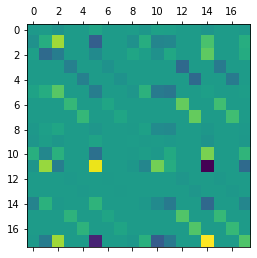

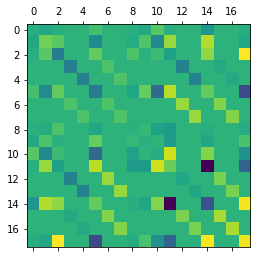

In [23]:
plt.matshow(dm1),plt.matshow(dP_fd)
norm(dm1),norm(dP_fd),norm(dm1-dP_fd)

In [24]:
h1ao=h1[2]

In [25]:
numpy.einsum('pq,pq', h1ao, dm1),numpy.einsum('pq,pq', h1ao, dP_fd)

(0.5881628203830618, 0.5884961311888581)

# Comments:
Unfortunatly the density deriv. analytical differs from the one by finite difference, though they give the same integration results with h1ao, that means that they can be used to evalaute derivatives, and probabily the density matrix is degenerate (which is possible given the high symmetry of the system) :(


In [37]:
def gen_vind(mf, mo_coeff, mo_occ):
    nao, nmo = mo_coeff.shape
    mocc = mo_coeff[:,mo_occ>0]
    nocc = mocc.shape[1]
    vresp = mf.gen_response(mo_coeff, mo_occ, hermi=1)
    def fx(mo1):
        mo1 = mo1.reshape(-1,nmo,nocc)
        nset = len(mo1)
        dm1 = numpy.empty((nset,nao,nao))
        for i, x in enumerate(mo1):
            dm = reduce(numpy.dot, (mo_coeff, x*2, mocc.T)) # *2 for double occupancy
            dm1[i] = dm + dm.T
        v1 = vresp(dm1)
        v1vo = numpy.empty_like(mo1)
        for i, x in enumerate(v1):
            v1vo[i] = reduce(numpy.dot, (mo_coeff.T, x, mocc))
        return v1vo
    return fx
fx = gen_vind(mf, mo_coeff, mo_occ)

In [27]:
def _ao2mo(mat):
        return numpy.asarray([reduce(numpy.dot, (mo_coeff.T, x, mocc)) for x in mat])

In [72]:
def solve_mo1(mf, mo_energy, mo_coeff, mo_occ, h1ao_or_chkfile,
              fx=None, atmlst=None, max_memory=4000, verbose=None):
    '''Solve the first order equation

    Kwargs:
        fx : function(dm_mo) => v1_mo
            A function to generate the induced potential.
            See also the function gen_vind.
    '''
    mol = mf.mol
    atmlst = range(mol.natm)

    nao, nmo = mo_coeff.shape
    mocc = mo_coeff[:,mo_occ>0]
    nocc = mocc.shape[1]

    fx = gen_vind(mf, mo_coeff, mo_occ)
    s1a = -mol.intor('int1e_ipovlp', comp=3)

    def _ao2mo(mat):
        return numpy.asarray([reduce(numpy.dot, (mo_coeff.T, x, mocc)) for x in mat])

    mem_now = lib.current_memory()[0]
    max_memory = max(2000, max_memory*.9-mem_now)
    blksize = max(2, int(max_memory*1e6/8 / (nmo*nocc*3*6)))
    mo1s = [None] * mol.natm    # s = solution
    e1s = [None] * mol.natm     # s = solution
    aoslices = mol.aoslice_by_atom()
    for ia0, ia1 in lib.prange(0, len(atmlst), blksize):
        s1vo = []
        h1vo = []
        for i0 in range(ia0, ia1):
            ia = atmlst[i0]
            shl0, shl1, p0, p1 = aoslices[ia]
            s1ao = numpy.zeros((3,nao,nao))
            s1ao[:,p0:p1] += s1a[:,p0:p1]
            s1ao[:,:,p0:p1] += s1a[:,p0:p1].transpose(0,2,1)
            s1vo.append(_ao2mo(s1ao))
            h1ao = h1ao_or_chkfile[ia]
            h1vo.append(_ao2mo(h1ao))
        h1vo = numpy.vstack(h1vo)
        s1vo = numpy.vstack(s1vo)
        return (mo_energy, mo_occ, h1vo, s1o)
        mo1, e1 = cphf.solve(fx, mo_energy, mo_occ, h1vo, s1vo)
        mo1 = numpy.einsum('pq,xqi->xpi', mo_coeff, mo1).reshape(-1,3,nao,nocc)
        e1 = e1.reshape(-1,3,nocc,nocc)

        for k in range(ia1-ia0):
            ia = atmlst[k+ia0]
            mo1s[ia] = mo1[k]
            e1s[ia] = e1[k].reshape(3,nocc,nocc)
        mo1 = e1 = None

    return mo1s, e1s

(3.7107760459963344, 4.095506981065465, 1.7330085309702807)

In [40]:
atmlst = range(mol.natm)
nao, nmo = mo_coeff.shape
mocc = mo_coeff[:,mo_occ>0]
nocc = mocc.shape[1]

In [75]:
mol=nn
s1a = -mol.intor('int1e_ipovlp', comp=3)
mem_now = lib.current_memory()[0]
max_memory = max(2000, max_memory*.9-mem_now)
ia0, ia1=0,2
s1vo = []
h1vo = []
for i0 in range(ia0, ia1):   # sei nel range di memoria i0 e' l'atomo rispetto al quale derivi
    ia = atmlst[i0]
    shl0, shl1, p0, p1 = aoslices[ia]
    s1ao = numpy.zeros((3,nao,nao))
    s1ao[:,p0:p1] += s1a[:,p0:p1]
    s1ao[:,:,p0:p1] += s1a[:,p0:p1].transpose(0,2,1)

In [76]:
print(norm(s1ao[2]-dS))

0.0003968137125041214


In [71]:
dS_vo =_ao2mo(dS)
dh1_vo=_ao2mo(h1[2])

In [50]:
mo1, e1 = cphf.solve(fx, mo_energy, mo_occ, dh1_vo, dS_vo)
dm1 = numpy.einsum('pi,qi->pq', mo1, mocc)*4

#mo1, mo_e1 = solve_mo1(mf,mo_energy, mo_coeff, mo_occ, h_nn.make_h1(mf.mo_coeff,mf.mo_occ),None, atmlst, max_memory, log)
#dm1 = numpy.einsum('pi,qi->pq', mo1[1][2], mocc)*4

h1ao=h1[2]

In [53]:
mo_energy_out, mo_occ_out, dh1_vo_out, dS_vo_out=solve_mo1(mf,mo_energy, mo_coeff, mo_occ, h_nn.make_h1(mf.mo_coeff,mf.mo_occ),None, atmlst, max_memory, log)

In [77]:
norm(dS_vo_out-np.vstack(_ao2mo(s1ao)))

ValueError: operands could not be broadcast together with shapes (6,18,7) (54,7) 

In [67]:
norm(dS_vo_out[1]-s1ao)

ValueError: operands could not be broadcast together with shapes (18,7) (3,18,18) 

In [51]:
numpy.einsum('pq,pq', h1ao, dm1),numpy.einsum('pq,pq', h1ao, dP_fd)

(-6.762066413926836, 0.5884961311888581)